<a href="https://colab.research.google.com/github/palashbaranwal/MNIST_BatchNorm_Regularization/blob/master/Assignment_6_L1_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

print(1+10)


11


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


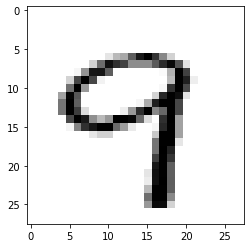

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

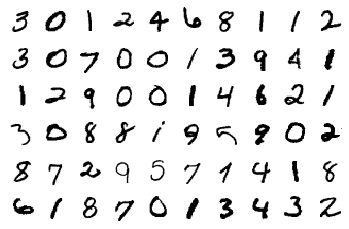

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        # self.convblock4 = nn.Sequential(
        #     nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            
        #     nn.ReLU()
        # ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        #     nn.BatchNorm2d(10),
        #     nn.ReLU()
        # ) # output_size = 7
         
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 5

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 3

        # self.convblock9 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        # ) # output_size = 5

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1



        # self.convblock8 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
        #     # nn.BatchNorm2d(10), NEVER
        #     # nn.ReLU() NEVER!
        # ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        #x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        #x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        #x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))
print("Check {0}",str("1+2"))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 10, 22, 22]             900
       BatchNorm2d-8           [-1, 10, 22, 22]              20
              ReLU-9           [-1, 10, 22, 22]               0
        MaxPool2d-10           [-1, 10, 11, 11]               0
           Conv2d-11             [-1, 10, 9, 9]             900
      BatchNorm2d-12             [-1, 10, 9, 9]              20
             ReLU-13             [-1, 10, 9, 9]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    reg_loss = 0 
    #l1_crit = nn.L1Loss(size_average=False)
    for param in model.parameters():
      if param.dim()>1:
        reg_loss +=  param.norm(1)
      #reg_loss+=l1_crit(param)

    factor = 0.0005
    loss += factor * reg_loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [17]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)



  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0




Loss=2.5870072841644287 Batch_id=0 Accuracy=7.03:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=2.5870072841644287 Batch_id=0 Accuracy=7.03:   0%|          | 1/469 [00:00<02:13,  3.51it/s]

Loss=2.5507683753967285 Batch_id=1 Accuracy=8.20:   0%|          | 1/469 [00:00<02:13,  3.51it/s]

Loss=2.5064525604248047 Batch_id=2 Accuracy=8.85:   0%|          | 1/469 [00:00<02:13,  3.51it/s]

Loss=2.4501092433929443 Batch_id=3 Accuracy=11.72:   0%|          | 1/469 [00:00<02:13,  3.51it/s]

Loss=2.3494081497192383 Batch_id=4 Accuracy=15.62:   0%|          | 1/469 [00:00<02:13,  3.51it/s]

Loss=2.3494081497192383 Batch_id=4 Accuracy=15.62:   1%|          | 5/469 [00:00<01:36,  4.78it/s]

Loss=2.318788766860962 Batch_id=5 Accuracy=17.84:   1%|          | 5/469 [00:00<01:36,  4.78it/s] 

Loss=2.3068602085113525 Batch_id=6 Accuracy=20.09:   1%|          | 5/469 [00:00<01:36,  4.78it/s]

Loss=2.2033004760742188 Batch_id=7 Accuracy=23.34:   1%|          | 5/469 [00:00<01:36,  4.78it/s]

Loss=2.193


Test set: Average loss: 0.1254, Accuracy: 9827/10000 (98.27%)

EPOCH: 1




Loss=0.24809356033802032 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.24809356033802032 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:09,  3.61it/s]

Loss=0.2591395378112793 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:09,  3.61it/s] 

Loss=0.2622065246105194 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:09,  3.61it/s]

Loss=0.2720271944999695 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<02:09,  3.61it/s]

Loss=0.31036221981048584 Batch_id=4 Accuracy=97.97:   0%|          | 1/469 [00:00<02:09,  3.61it/s]

Loss=0.31036221981048584 Batch_id=4 Accuracy=97.97:   1%|          | 5/469 [00:00<01:33,  4.94it/s]

Loss=0.2603301405906677 Batch_id=5 Accuracy=98.05:   1%|          | 5/469 [00:00<01:33,  4.94it/s] 

Loss=0.23225095868110657 Batch_id=6 Accuracy=98.10:   1%|          | 5/469 [00:00<01:33,  4.94it/s]

Loss=0.33528056740760803 Batch_id=7 Accuracy=97.75:   1%|          | 5/469 [00:00<01:33,  4.94it/s]


Test set: Average loss: 0.0651, Accuracy: 9851/10000 (98.51%)

EPOCH: 2




Loss=0.17038165032863617 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.17038165032863617 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<01:55,  4.04it/s]

Loss=0.20361028611660004 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<01:55,  4.04it/s]

Loss=0.18634670972824097 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<01:55,  4.04it/s]

Loss=0.22994792461395264 Batch_id=3 Accuracy=97.85:   0%|          | 1/469 [00:00<01:55,  4.04it/s]

Loss=0.2242695689201355 Batch_id=4 Accuracy=97.81:   0%|          | 1/469 [00:00<01:55,  4.04it/s] 

Loss=0.2242695689201355 Batch_id=4 Accuracy=97.81:   1%|          | 5/469 [00:00<01:24,  5.51it/s]

Loss=0.17026732861995697 Batch_id=5 Accuracy=98.05:   1%|          | 5/469 [00:00<01:24,  5.51it/s]

Loss=0.18411414325237274 Batch_id=6 Accuracy=98.21:   1%|          | 5/469 [00:00<01:24,  5.51it/s]

Loss=0.16501349210739136 Batch_id=7 Accuracy=98.34:   1%|          | 5/469 [00:00<01:24,  5.51it/s


Test set: Average loss: 0.0632, Accuracy: 9876/10000 (98.76%)

EPOCH: 3




Loss=0.16599227488040924 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.16599227488040924 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:17,  3.40it/s]

Loss=0.18146151304244995 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:17,  3.40it/s]

Loss=0.1380271017551422 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<02:17,  3.40it/s] 

Loss=0.15263241529464722 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<02:17,  3.40it/s]

Loss=0.17601285874843597 Batch_id=4 Accuracy=98.75:   0%|          | 1/469 [00:00<02:17,  3.40it/s]

Loss=0.17601285874843597 Batch_id=4 Accuracy=98.75:   1%|          | 5/469 [00:00<01:39,  4.65it/s]

Loss=0.13875454664230347 Batch_id=5 Accuracy=98.70:   1%|          | 5/469 [00:00<01:39,  4.65it/s]

Loss=0.13560575246810913 Batch_id=6 Accuracy=98.88:   1%|          | 5/469 [00:00<01:39,  4.65it/s]

Loss=0.1776772290468216 Batch_id=7 Accuracy=98.93:   1%|          | 5/469 [00:00<01:39,  4.65it/s


Test set: Average loss: 0.0685, Accuracy: 9812/10000 (98.12%)

EPOCH: 4




Loss=0.1814361959695816 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.1814361959695816 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:15,  3.44it/s]

Loss=0.13597482442855835 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:15,  3.44it/s]

Loss=0.12160088121891022 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<02:15,  3.44it/s]

Loss=0.1475265920162201 Batch_id=3 Accuracy=98.83:   0%|          | 1/469 [00:00<02:15,  3.44it/s] 

Loss=0.1725093424320221 Batch_id=4 Accuracy=98.91:   0%|          | 1/469 [00:00<02:15,  3.44it/s]

Loss=0.1725093424320221 Batch_id=4 Accuracy=98.91:   1%|          | 5/469 [00:00<01:38,  4.71it/s]

Loss=0.13976013660430908 Batch_id=5 Accuracy=98.83:   1%|          | 5/469 [00:00<01:38,  4.71it/s]

Loss=0.1813162863254547 Batch_id=6 Accuracy=98.55:   1%|          | 5/469 [00:00<01:38,  4.71it/s] 

Loss=0.13828501105308533 Batch_id=7 Accuracy=98.54:   1%|          | 5/469 [00:00<01:38,  4.71it/s]




Test set: Average loss: 0.0650, Accuracy: 9831/10000 (98.31%)

EPOCH: 5




Loss=0.14107149839401245 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.14107149839401245 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:10,  3.58it/s]

Loss=0.15614473819732666 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:10,  3.58it/s]

Loss=0.15972116589546204 Batch_id=2 Accuracy=97.92:   0%|          | 1/469 [00:00<02:10,  3.58it/s]

Loss=0.15137065947055817 Batch_id=3 Accuracy=97.66:   0%|          | 1/469 [00:00<02:10,  3.58it/s]

Loss=0.15137065947055817 Batch_id=3 Accuracy=97.66:   1%|          | 4/469 [00:00<01:36,  4.84it/s]

Loss=0.12196137011051178 Batch_id=4 Accuracy=98.12:   1%|          | 4/469 [00:00<01:36,  4.84it/s]

Loss=0.13467198610305786 Batch_id=5 Accuracy=98.18:   1%|          | 4/469 [00:00<01:36,  4.84it/s]

Loss=0.16128620505332947 Batch_id=6 Accuracy=98.21:   1%|          | 4/469 [00:00<01:36,  4.84it/s]

Loss=0.15703749656677246 Batch_id=7 Accuracy=98.24:   1%|          | 4/469 [00:00<01:36,  4.84it/


Test set: Average loss: 0.0636, Accuracy: 9833/10000 (98.33%)

EPOCH: 6




Loss=0.124849334359169 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.124849334359169 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:19,  3.36it/s]

Loss=0.12816880643367767 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:19,  3.36it/s]

Loss=0.1911277174949646 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<02:19,  3.36it/s] 

Loss=0.11604884266853333 Batch_id=3 Accuracy=98.83:   0%|          | 1/469 [00:00<02:19,  3.36it/s]

Loss=0.1287073791027069 Batch_id=4 Accuracy=98.91:   0%|          | 1/469 [00:00<02:19,  3.36it/s] 

Loss=0.1287073791027069 Batch_id=4 Accuracy=98.91:   1%|          | 5/469 [00:00<01:40,  4.62it/s]

Loss=0.1559029370546341 Batch_id=5 Accuracy=98.70:   1%|          | 5/469 [00:00<01:40,  4.62it/s]

Loss=0.1808803677558899 Batch_id=6 Accuracy=98.66:   1%|          | 5/469 [00:00<01:40,  4.62it/s]

Loss=0.11033640801906586 Batch_id=7 Accuracy=98.83:   1%|          | 5/469 [00:00<01:40,  4.62it/s]

Los


Test set: Average loss: 0.0537, Accuracy: 9861/10000 (98.61%)

EPOCH: 7




Loss=0.13829541206359863 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.13829541206359863 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:02,  3.81it/s]

Loss=0.11708889901638031 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:02,  3.81it/s]

Loss=0.1519910991191864 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<02:02,  3.81it/s] 

Loss=0.13491275906562805 Batch_id=3 Accuracy=98.63:   0%|          | 1/469 [00:00<02:02,  3.81it/s]

Loss=0.12519918382167816 Batch_id=4 Accuracy=98.59:   0%|          | 1/469 [00:00<02:02,  3.81it/s]

Loss=0.12519918382167816 Batch_id=4 Accuracy=98.59:   1%|          | 5/469 [00:00<01:29,  5.18it/s]

Loss=0.118024542927742 Batch_id=5 Accuracy=98.70:   1%|          | 5/469 [00:00<01:29,  5.18it/s]  

Loss=0.17016500234603882 Batch_id=6 Accuracy=98.33:   1%|          | 5/469 [00:00<01:29,  5.18it/s]

Loss=0.15126490592956543 Batch_id=7 Accuracy=98.24:   1%|          | 5/469 [00:00<01:29,  5.18it/


Test set: Average loss: 0.0411, Accuracy: 9892/10000 (98.92%)

EPOCH: 8




Loss=0.1306583732366562 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.1306583732366562 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<01:41,  4.62it/s]

Loss=0.15503697097301483 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<01:41,  4.62it/s]

Loss=0.11876001209020615 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<01:41,  4.62it/s]

Loss=0.11876001209020615 Batch_id=2 Accuracy=98.44:   1%|          | 3/469 [00:00<01:18,  5.94it/s]

Loss=0.17995156347751617 Batch_id=3 Accuracy=98.05:   1%|          | 3/469 [00:00<01:18,  5.94it/s]

Loss=0.12003657221794128 Batch_id=4 Accuracy=98.12:   1%|          | 3/469 [00:00<01:18,  5.94it/s]

Loss=0.10997611284255981 Batch_id=5 Accuracy=98.31:   1%|          | 3/469 [00:00<01:18,  5.94it/s]

Loss=0.16965006291866302 Batch_id=6 Accuracy=98.21:   1%|          | 3/469 [00:00<01:18,  5.94it/s]

Loss=0.16965006291866302 Batch_id=6 Accuracy=98.21:   1%|▏         | 7/469 [00:00<00:58,  7.91it/s]


Test set: Average loss: 0.0518, Accuracy: 9853/10000 (98.53%)

EPOCH: 9




Loss=0.11908859014511108 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.11908859014511108 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:14,  3.49it/s]

Loss=0.14908641576766968 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:14,  3.49it/s]

Loss=0.16186796128749847 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<02:14,  3.49it/s]

Loss=0.11027039587497711 Batch_id=3 Accuracy=98.83:   0%|          | 1/469 [00:00<02:14,  3.49it/s]

Loss=0.160573810338974 Batch_id=4 Accuracy=98.59:   0%|          | 1/469 [00:00<02:14,  3.49it/s]  

Loss=0.160573810338974 Batch_id=4 Accuracy=98.59:   1%|          | 5/469 [00:00<01:37,  4.76it/s]

Loss=0.22055557370185852 Batch_id=5 Accuracy=98.31:   1%|          | 5/469 [00:00<01:37,  4.76it/s]

Loss=0.11670804768800735 Batch_id=6 Accuracy=98.44:   1%|          | 5/469 [00:00<01:37,  4.76it/s]

Loss=0.14137157797813416 Batch_id=7 Accuracy=98.54:   1%|          | 5/469 [00:00<01:37,  4.76it/s]


Test set: Average loss: 0.0633, Accuracy: 9821/10000 (98.21%)

EPOCH: 10




Loss=0.09859086573123932 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.09859086573123932 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<01:43,  4.53it/s]

Loss=0.12203419208526611 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<01:43,  4.53it/s] 

Loss=0.14630527794361115 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<01:43,  4.53it/s]

Loss=0.14630527794361115 Batch_id=2 Accuracy=98.96:   1%|          | 3/469 [00:00<01:19,  5.85it/s]

Loss=0.1642579883337021 Batch_id=3 Accuracy=98.44:   1%|          | 3/469 [00:00<01:19,  5.85it/s] 

Loss=0.15011221170425415 Batch_id=4 Accuracy=98.28:   1%|          | 3/469 [00:00<01:19,  5.85it/s]

Loss=0.10654477775096893 Batch_id=5 Accuracy=98.44:   1%|          | 3/469 [00:00<01:19,  5.85it/s]

Loss=0.1533048003911972 Batch_id=6 Accuracy=98.44:   1%|          | 3/469 [00:00<01:19,  5.85it/s] 

Loss=0.1533048003911972 Batch_id=6 Accuracy=98.44:   1%|▏         | 7/469 [00:00<00:58,  7.84i


Test set: Average loss: 0.0603, Accuracy: 9834/10000 (98.34%)

EPOCH: 11




Loss=0.1450684666633606 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.1450684666633606 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:07,  3.66it/s]

Loss=0.1143026351928711 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:07,  3.66it/s]

Loss=0.12395600229501724 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:07,  3.66it/s]

Loss=0.1499941498041153 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<02:07,  3.66it/s] 

Loss=0.16468219459056854 Batch_id=4 Accuracy=98.75:   0%|          | 1/469 [00:00<02:07,  3.66it/s]

Loss=0.13689085841178894 Batch_id=5 Accuracy=98.70:   0%|          | 1/469 [00:00<02:07,  3.66it/s]

Loss=0.13689085841178894 Batch_id=5 Accuracy=98.70:   1%|▏         | 6/469 [00:00<01:31,  5.04it/s]

Loss=0.17686548829078674 Batch_id=6 Accuracy=98.66:   1%|▏         | 6/469 [00:00<01:31,  5.04it/s]

Loss=0.11819349229335785 Batch_id=7 Accuracy=98.73:   1%|▏         | 6/469 [00:00<01:31,  5.04it/s]



Test set: Average loss: 0.0537, Accuracy: 9837/10000 (98.37%)

EPOCH: 12




Loss=0.18666820228099823 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.18666820228099823 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<01:47,  4.33it/s]

Loss=0.17164455354213715 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<01:47,  4.33it/s]

Loss=0.2217211127281189 Batch_id=2 Accuracy=97.92:   0%|          | 1/469 [00:00<01:47,  4.33it/s] 

Loss=0.1678847074508667 Batch_id=3 Accuracy=97.85:   0%|          | 1/469 [00:00<01:47,  4.33it/s]

Loss=0.1678847074508667 Batch_id=3 Accuracy=97.85:   1%|          | 4/469 [00:00<01:20,  5.79it/s]

Loss=0.11174841970205307 Batch_id=4 Accuracy=97.97:   1%|          | 4/469 [00:00<01:20,  5.79it/s]

Loss=0.11014314740896225 Batch_id=5 Accuracy=98.18:   1%|          | 4/469 [00:00<01:20,  5.79it/s]

Loss=0.12664735317230225 Batch_id=6 Accuracy=98.33:   1%|          | 4/469 [00:00<01:20,  5.79it/s]

Loss=0.15669769048690796 Batch_id=7 Accuracy=98.34:   1%|          | 4/469 [00:00<01:20,  5.79it/s]


Test set: Average loss: 0.0516, Accuracy: 9854/10000 (98.54%)

EPOCH: 13




Loss=0.2105393409729004 Batch_id=0 Accuracy=95.31:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.2105393409729004 Batch_id=0 Accuracy=95.31:   0%|          | 1/469 [00:00<02:18,  3.37it/s]

Loss=0.13091827929019928 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<02:18,  3.37it/s]

Loss=0.13634738326072693 Batch_id=2 Accuracy=97.66:   0%|          | 1/469 [00:00<02:18,  3.37it/s]

Loss=0.1205616146326065 Batch_id=3 Accuracy=98.05:   0%|          | 1/469 [00:00<02:18,  3.37it/s] 

Loss=0.16353508830070496 Batch_id=4 Accuracy=97.97:   0%|          | 1/469 [00:00<02:18,  3.37it/s]

Loss=0.16353508830070496 Batch_id=4 Accuracy=97.97:   1%|          | 5/469 [00:00<01:40,  4.62it/s]

Loss=0.12043337523937225 Batch_id=5 Accuracy=98.18:   1%|          | 5/469 [00:00<01:40,  4.62it/s]

Loss=0.10235822200775146 Batch_id=6 Accuracy=98.44:   1%|          | 5/469 [00:00<01:40,  4.62it/s]

Loss=0.14514434337615967 Batch_id=7 Accuracy=98.44:   1%|          | 5/469 [00:00<01:40,  4.62it/s]


Test set: Average loss: 0.0437, Accuracy: 9881/10000 (98.81%)

EPOCH: 14




Loss=0.1325386017560959 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.1325386017560959 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<01:38,  4.77it/s]

Loss=0.1376853883266449 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<01:38,  4.77it/s]

Loss=0.1376853883266449 Batch_id=1 Accuracy=98.83:   0%|          | 2/469 [00:00<01:22,  5.64it/s]

Loss=0.1403743326663971 Batch_id=2 Accuracy=98.70:   0%|          | 2/469 [00:00<01:22,  5.64it/s]

Loss=0.1418176293373108 Batch_id=3 Accuracy=98.83:   0%|          | 2/469 [00:00<01:22,  5.64it/s]

Loss=0.16806583106517792 Batch_id=4 Accuracy=98.44:   0%|          | 2/469 [00:00<01:22,  5.64it/s]

Loss=0.11979459226131439 Batch_id=5 Accuracy=98.57:   0%|          | 2/469 [00:00<01:22,  5.64it/s]

Loss=0.11979459226131439 Batch_id=5 Accuracy=98.57:   1%|▏         | 6/469 [00:00<01:01,  7.56it/s]

Loss=0.11055973172187805 Batch_id=6 Accuracy=98.55:   1%|▏         | 6/469 [00:00<01:01,  7.56it/s]

Lo


Test set: Average loss: 0.0846, Accuracy: 9728/10000 (97.28%)

EPOCH: 15




Loss=0.13769970834255219 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.13769970834255219 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:12,  3.53it/s]

Loss=0.1298956423997879 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:12,  3.53it/s] 

Loss=0.14031609892845154 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:12,  3.53it/s]

Loss=0.19580665230751038 Batch_id=3 Accuracy=98.63:   0%|          | 1/469 [00:00<02:12,  3.53it/s]

Loss=0.15910625457763672 Batch_id=4 Accuracy=98.44:   0%|          | 1/469 [00:00<02:12,  3.53it/s]

Loss=0.15910625457763672 Batch_id=4 Accuracy=98.44:   1%|          | 5/469 [00:00<01:35,  4.83it/s]

Loss=0.10683241486549377 Batch_id=5 Accuracy=98.70:   1%|          | 5/469 [00:00<01:35,  4.83it/s]

Loss=0.13253355026245117 Batch_id=6 Accuracy=98.66:   1%|          | 5/469 [00:00<01:35,  4.83it/s]

Loss=0.12267698347568512 Batch_id=7 Accuracy=98.73:   1%|          | 5/469 [00:00<01:35,  4.83it/


Test set: Average loss: 0.0424, Accuracy: 9889/10000 (98.89%)

EPOCH: 16




Loss=0.16718116402626038 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.16718116402626038 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:19,  3.36it/s]

Loss=0.13575945794582367 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:19,  3.36it/s]

Loss=0.20471243560314178 Batch_id=2 Accuracy=97.40:   0%|          | 1/469 [00:00<02:19,  3.36it/s]

Loss=0.12649095058441162 Batch_id=3 Accuracy=97.66:   0%|          | 1/469 [00:00<02:19,  3.36it/s]

Loss=0.1477021425962448 Batch_id=4 Accuracy=97.66:   0%|          | 1/469 [00:00<02:19,  3.36it/s] 

Loss=0.1477021425962448 Batch_id=4 Accuracy=97.66:   1%|          | 5/469 [00:00<01:40,  4.62it/s]

Loss=0.12856949865818024 Batch_id=5 Accuracy=97.79:   1%|          | 5/469 [00:00<01:40,  4.62it/s]

Loss=0.11421014368534088 Batch_id=6 Accuracy=98.10:   1%|          | 5/469 [00:00<01:40,  4.62it/s]

Loss=0.11337153613567352 Batch_id=7 Accuracy=98.14:   1%|          | 5/469 [00:00<01:40,  4.62it/s


Test set: Average loss: 0.0436, Accuracy: 9883/10000 (98.83%)

EPOCH: 17




Loss=0.11940208822488785 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.11940208822488785 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:15,  3.45it/s]

Loss=0.13474340736865997 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:15,  3.45it/s]

Loss=0.1623632162809372 Batch_id=2 Accuracy=97.92:   0%|          | 1/469 [00:00<02:15,  3.45it/s] 

Loss=0.1512182205915451 Batch_id=3 Accuracy=98.05:   0%|          | 1/469 [00:00<02:15,  3.45it/s]

Loss=0.17554377019405365 Batch_id=4 Accuracy=97.66:   0%|          | 1/469 [00:00<02:15,  3.45it/s]

Loss=0.15270625054836273 Batch_id=5 Accuracy=97.66:   0%|          | 1/469 [00:00<02:15,  3.45it/s]

Loss=0.15270625054836273 Batch_id=5 Accuracy=97.66:   1%|▏         | 6/469 [00:00<01:37,  4.77it/s]

Loss=0.13549204170703888 Batch_id=6 Accuracy=97.77:   1%|▏         | 6/469 [00:00<01:37,  4.77it/s]

Loss=0.10316197574138641 Batch_id=7 Accuracy=98.05:   1%|▏         | 6/469 [00:00<01:37,  4.77it/s


Test set: Average loss: 0.0437, Accuracy: 9870/10000 (98.70%)

EPOCH: 18




Loss=0.14986008405685425 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.14986008405685425 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:07,  3.67it/s]

Loss=0.10084633529186249 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:07,  3.67it/s]

Loss=0.10969086736440659 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<02:07,  3.67it/s]

Loss=0.1556803584098816 Batch_id=3 Accuracy=98.83:   0%|          | 1/469 [00:00<02:07,  3.67it/s] 

Loss=0.1556803584098816 Batch_id=3 Accuracy=98.83:   1%|          | 4/469 [00:00<01:34,  4.93it/s]

Loss=0.1529143750667572 Batch_id=4 Accuracy=98.44:   1%|          | 4/469 [00:00<01:34,  4.93it/s]

Loss=0.16047470271587372 Batch_id=5 Accuracy=98.18:   1%|          | 4/469 [00:00<01:34,  4.93it/s]

Loss=0.17577597498893738 Batch_id=6 Accuracy=98.10:   1%|          | 4/469 [00:00<01:34,  4.93it/s]

Loss=0.19445335865020752 Batch_id=7 Accuracy=98.05:   1%|          | 4/469 [00:00<01:34,  4.93it/s]


Test set: Average loss: 0.0508, Accuracy: 9855/10000 (98.55%)

EPOCH: 19




Loss=0.10698380321264267 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.10698380321264267 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:22,  3.29it/s]

Loss=0.15431863069534302 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:22,  3.29it/s] 

Loss=0.13573554158210754 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<02:22,  3.29it/s]

Loss=0.2180938422679901 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<02:22,  3.29it/s] 

Loss=0.12848077714443207 Batch_id=4 Accuracy=98.12:   0%|          | 1/469 [00:00<02:22,  3.29it/s]

Loss=0.12848077714443207 Batch_id=4 Accuracy=98.12:   1%|          | 5/469 [00:00<01:42,  4.53it/s]

Loss=0.11775582283735275 Batch_id=5 Accuracy=98.31:   1%|          | 5/469 [00:00<01:42,  4.53it/s]

Loss=0.11116110533475876 Batch_id=6 Accuracy=98.44:   1%|          | 5/469 [00:00<01:42,  4.53it/s]

Loss=0.1252531111240387 Batch_id=7 Accuracy=98.54:   1%|          | 5/469 [00:00<01:42,  4.53i


Test set: Average loss: 0.0436, Accuracy: 9890/10000 (98.90%)

EPOCH: 20




Loss=0.17044618725776672 Batch_id=0 Accuracy=96.88:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.17044618725776672 Batch_id=0 Accuracy=96.88:   0%|          | 1/469 [00:00<02:19,  3.37it/s]

Loss=0.14880265295505524 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:19,  3.37it/s]

Loss=0.19667652249336243 Batch_id=2 Accuracy=97.66:   0%|          | 1/469 [00:00<02:19,  3.37it/s]

Loss=0.13633736968040466 Batch_id=3 Accuracy=97.66:   0%|          | 1/469 [00:00<02:19,  3.37it/s]

Loss=0.19073951244354248 Batch_id=4 Accuracy=97.81:   0%|          | 1/469 [00:00<02:19,  3.37it/s]

Loss=0.13795512914657593 Batch_id=5 Accuracy=97.79:   0%|          | 1/469 [00:00<02:19,  3.37it/s]

Loss=0.13795512914657593 Batch_id=5 Accuracy=97.79:   1%|▏         | 6/469 [00:00<01:39,  4.67it/s]

Loss=0.14627492427825928 Batch_id=6 Accuracy=97.99:   1%|▏         | 6/469 [00:00<01:39,  4.67it/s]

Loss=0.12800975143909454 Batch_id=7 Accuracy=98.05:   1%|▏         | 6/469 [00:00<01:39,  4.67it/


Test set: Average loss: 0.0720, Accuracy: 9770/10000 (97.70%)

EPOCH: 21




Loss=0.13364163041114807 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.13364163041114807 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:08,  3.64it/s]

Loss=0.13389968872070312 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:08,  3.64it/s]

Loss=0.11623305082321167 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<02:08,  3.64it/s]

Loss=0.14013484120368958 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<02:08,  3.64it/s]

Loss=0.1408979892730713 Batch_id=4 Accuracy=98.12:   0%|          | 1/469 [00:00<02:08,  3.64it/s] 

Loss=0.1408979892730713 Batch_id=4 Accuracy=98.12:   1%|          | 5/469 [00:00<01:33,  4.96it/s]

Loss=0.15467283129692078 Batch_id=5 Accuracy=97.92:   1%|          | 5/469 [00:00<01:33,  4.96it/s]

Loss=0.13281376659870148 Batch_id=6 Accuracy=97.99:   1%|          | 5/469 [00:00<01:33,  4.96it/s]

Loss=0.16761378943920135 Batch_id=7 Accuracy=97.95:   1%|          | 5/469 [00:00<01:33,  4.96it/s


Test set: Average loss: 0.0467, Accuracy: 9856/10000 (98.56%)

EPOCH: 22




Loss=0.16812479496002197 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.16812479496002197 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:03,  3.80it/s]

Loss=0.2446681559085846 Batch_id=1 Accuracy=96.88:   0%|          | 1/469 [00:00<02:03,  3.80it/s] 

Loss=0.17559939622879028 Batch_id=2 Accuracy=97.40:   0%|          | 1/469 [00:00<02:03,  3.80it/s]

Loss=0.123691126704216 Batch_id=3 Accuracy=97.66:   0%|          | 1/469 [00:00<02:03,  3.80it/s]  

Loss=0.123691126704216 Batch_id=3 Accuracy=97.66:   1%|          | 4/469 [00:00<01:30,  5.14it/s]

Loss=0.1558089703321457 Batch_id=4 Accuracy=97.97:   1%|          | 4/469 [00:00<01:30,  5.14it/s]

Loss=0.13460412621498108 Batch_id=5 Accuracy=98.18:   1%|          | 4/469 [00:00<01:30,  5.14it/s]

Loss=0.14779740571975708 Batch_id=6 Accuracy=97.99:   1%|          | 4/469 [00:00<01:30,  5.14it/s]

Loss=0.11211120337247849 Batch_id=7 Accuracy=98.14:   1%|          | 4/469 [00:00<01:30,  5.14it/s]



Test set: Average loss: 0.0379, Accuracy: 9894/10000 (98.94%)

EPOCH: 23




Loss=0.24854175746440887 Batch_id=0 Accuracy=95.31:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.24854175746440887 Batch_id=0 Accuracy=95.31:   0%|          | 1/469 [00:00<02:20,  3.34it/s]

Loss=0.10445553064346313 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<02:20,  3.34it/s]

Loss=0.13825476169586182 Batch_id=2 Accuracy=97.66:   0%|          | 1/469 [00:00<02:20,  3.34it/s]

Loss=0.10383271425962448 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<02:20,  3.34it/s]

Loss=0.09404703974723816 Batch_id=4 Accuracy=98.59:   0%|          | 1/469 [00:00<02:20,  3.34it/s]

Loss=0.09404703974723816 Batch_id=4 Accuracy=98.59:   1%|          | 5/469 [00:00<01:40,  4.60it/s]

Loss=0.10499054193496704 Batch_id=5 Accuracy=98.70:   1%|          | 5/469 [00:00<01:40,  4.60it/s]

Loss=0.132515549659729 Batch_id=6 Accuracy=98.55:   1%|          | 5/469 [00:00<01:40,  4.60it/s]  

Loss=0.1991511583328247 Batch_id=7 Accuracy=98.14:   1%|          | 5/469 [00:00<01:40,  4.60it/s


Test set: Average loss: 0.0786, Accuracy: 9750/10000 (97.50%)

EPOCH: 24




Loss=0.12740525603294373 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.12740525603294373 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:25,  3.22it/s]

Loss=0.13300907611846924 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:25,  3.22it/s]

Loss=0.11271622776985168 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:25,  3.22it/s]

Loss=0.16957244277000427 Batch_id=3 Accuracy=98.63:   0%|          | 1/469 [00:00<02:25,  3.22it/s]

Loss=0.14200878143310547 Batch_id=4 Accuracy=98.59:   0%|          | 1/469 [00:00<02:25,  3.22it/s]

Loss=0.14200878143310547 Batch_id=4 Accuracy=98.59:   1%|          | 5/469 [00:00<01:44,  4.43it/s]

Loss=0.11079099774360657 Batch_id=5 Accuracy=98.70:   1%|          | 5/469 [00:00<01:44,  4.43it/s]

Loss=0.141153484582901 Batch_id=6 Accuracy=98.66:   1%|          | 5/469 [00:00<01:44,  4.43it/s]  

Loss=0.10237486660480499 Batch_id=7 Accuracy=98.83:   1%|          | 5/469 [00:00<01:44,  4.43it/


Test set: Average loss: 0.0510, Accuracy: 9849/10000 (98.49%)

EPOCH: 25




Loss=0.12680591642856598 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.12680591642856598 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:20,  3.34it/s]

Loss=0.10023847222328186 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:20,  3.34it/s]

Loss=0.13061805069446564 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<02:20,  3.34it/s]

Loss=0.13130053877830505 Batch_id=3 Accuracy=98.44:   0%|          | 1/469 [00:00<02:20,  3.34it/s]

Loss=0.11993435770273209 Batch_id=4 Accuracy=98.59:   0%|          | 1/469 [00:00<02:20,  3.34it/s]

Loss=0.11993435770273209 Batch_id=4 Accuracy=98.59:   1%|          | 5/469 [00:00<01:41,  4.58it/s]

Loss=0.15706641972064972 Batch_id=5 Accuracy=98.44:   1%|          | 5/469 [00:00<01:41,  4.58it/s]

Loss=0.12463414669036865 Batch_id=6 Accuracy=98.44:   1%|          | 5/469 [00:00<01:41,  4.58it/s]

Loss=0.0998670905828476 Batch_id=7 Accuracy=98.63:   1%|          | 5/469 [00:00<01:41,  4.58it/s


Test set: Average loss: 0.0501, Accuracy: 9854/10000 (98.54%)

EPOCH: 26




Loss=0.12297166883945465 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.12297166883945465 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:25,  3.22it/s]

Loss=0.12076587975025177 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:25,  3.22it/s]

Loss=0.18205609917640686 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<02:25,  3.22it/s]

Loss=0.18139126896858215 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<02:25,  3.22it/s]

Loss=0.18139126896858215 Batch_id=3 Accuracy=98.24:   1%|          | 4/469 [00:00<01:46,  4.39it/s]

Loss=0.13322220742702484 Batch_id=4 Accuracy=98.28:   1%|          | 4/469 [00:00<01:46,  4.39it/s]

Loss=0.1290164440870285 Batch_id=5 Accuracy=98.31:   1%|          | 4/469 [00:00<01:46,  4.39it/s] 

Loss=0.14988599717617035 Batch_id=6 Accuracy=98.33:   1%|          | 4/469 [00:00<01:46,  4.39it/s]

Loss=0.14988599717617035 Batch_id=6 Accuracy=98.33:   1%|▏         | 7/469 [00:00<01:18,  5.88it/


Test set: Average loss: 0.0527, Accuracy: 9828/10000 (98.28%)

EPOCH: 27




Loss=0.12181675434112549 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.12181675434112549 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:03,  3.79it/s]

Loss=0.15795451402664185 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:03,  3.79it/s]

Loss=0.12022010236978531 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:03,  3.79it/s]

Loss=0.20107883214950562 Batch_id=3 Accuracy=98.44:   0%|          | 1/469 [00:00<02:03,  3.79it/s]

Loss=0.20107883214950562 Batch_id=3 Accuracy=98.44:   1%|          | 4/469 [00:00<01:31,  5.07it/s]

Loss=0.1414874643087387 Batch_id=4 Accuracy=98.44:   1%|          | 4/469 [00:00<01:31,  5.07it/s] 

Loss=0.12977643311023712 Batch_id=5 Accuracy=98.44:   1%|          | 4/469 [00:00<01:31,  5.07it/s]

Loss=0.15089648962020874 Batch_id=6 Accuracy=98.21:   1%|          | 4/469 [00:00<01:31,  5.07it/s]

Loss=0.2233262062072754 Batch_id=7 Accuracy=98.05:   1%|          | 4/469 [00:00<01:31,  5.07it/s


Test set: Average loss: 0.0437, Accuracy: 9891/10000 (98.91%)

EPOCH: 28




Loss=0.15115240216255188 Batch_id=0 Accuracy=96.88:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.15115240216255188 Batch_id=0 Accuracy=96.88:   0%|          | 1/469 [00:00<02:19,  3.36it/s]

Loss=0.12610822916030884 Batch_id=1 Accuracy=97.66:   0%|          | 1/469 [00:00<02:19,  3.36it/s]

Loss=0.12017658352851868 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:19,  3.36it/s]

Loss=0.17790305614471436 Batch_id=3 Accuracy=97.85:   0%|          | 1/469 [00:00<02:19,  3.36it/s]

Loss=0.11979667842388153 Batch_id=4 Accuracy=97.97:   0%|          | 1/469 [00:00<02:19,  3.36it/s]

Loss=0.11979667842388153 Batch_id=4 Accuracy=97.97:   1%|          | 5/469 [00:00<01:41,  4.59it/s]

Loss=0.11620305478572845 Batch_id=5 Accuracy=98.05:   1%|          | 5/469 [00:00<01:41,  4.59it/s]

Loss=0.13965857028961182 Batch_id=6 Accuracy=97.88:   1%|          | 5/469 [00:00<01:41,  4.59it/s]

Loss=0.16200804710388184 Batch_id=7 Accuracy=97.95:   1%|          | 5/469 [00:00<01:41,  4.59it/


Test set: Average loss: 0.0389, Accuracy: 9893/10000 (98.93%)

EPOCH: 29




Loss=0.1208956390619278 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.1208956390619278 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:15,  3.45it/s]

Loss=0.13982892036437988 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:15,  3.45it/s]

Loss=0.13981573283672333 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:15,  3.45it/s]

Loss=0.09489638358354568 Batch_id=3 Accuracy=98.63:   0%|          | 1/469 [00:00<02:15,  3.45it/s]

Loss=0.0916847288608551 Batch_id=4 Accuracy=98.91:   0%|          | 1/469 [00:00<02:15,  3.45it/s] 

Loss=0.0916847288608551 Batch_id=4 Accuracy=98.91:   1%|          | 5/469 [00:00<01:38,  4.72it/s]

Loss=0.12386664748191833 Batch_id=5 Accuracy=98.83:   1%|          | 5/469 [00:00<01:38,  4.72it/s]

Loss=0.10454746335744858 Batch_id=6 Accuracy=98.88:   1%|          | 5/469 [00:00<01:38,  4.72it/s]

Loss=0.11712227016687393 Batch_id=7 Accuracy=98.83:   1%|          | 5/469 [00:00<01:38,  4.72it/s]



Test set: Average loss: 0.0681, Accuracy: 9789/10000 (97.89%)

EPOCH: 30




Loss=0.12114448845386505 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.12114448845386505 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:17,  3.40it/s]

Loss=0.13045881688594818 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:17,  3.40it/s]

Loss=0.12725737690925598 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:17,  3.40it/s]

Loss=0.10782421380281448 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<02:17,  3.40it/s]

Loss=0.13767962157726288 Batch_id=4 Accuracy=99.06:   0%|          | 1/469 [00:00<02:17,  3.40it/s]

Loss=0.13767962157726288 Batch_id=4 Accuracy=99.06:   1%|          | 5/469 [00:00<01:39,  4.67it/s]

Loss=0.10151942074298859 Batch_id=5 Accuracy=99.09:   1%|          | 5/469 [00:00<01:39,  4.67it/s]

Loss=0.14836281538009644 Batch_id=6 Accuracy=99.00:   1%|          | 5/469 [00:00<01:39,  4.67it/s]

Loss=0.13732577860355377 Batch_id=7 Accuracy=98.93:   1%|          | 5/469 [00:00<01:39,  4.67it/


Test set: Average loss: 0.0376, Accuracy: 9878/10000 (98.78%)

EPOCH: 31




Loss=0.13259324431419373 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.13259324431419373 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:17,  3.40it/s]

Loss=0.10318928211927414 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:17,  3.40it/s]

Loss=0.12755148112773895 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<02:17,  3.40it/s]

Loss=0.1874985545873642 Batch_id=3 Accuracy=98.44:   0%|          | 1/469 [00:00<02:17,  3.40it/s] 

Loss=0.1874985545873642 Batch_id=3 Accuracy=98.44:   1%|          | 4/469 [00:00<01:40,  4.61it/s]

Loss=0.09448859095573425 Batch_id=4 Accuracy=98.75:   1%|          | 4/469 [00:00<01:40,  4.61it/s]

Loss=0.11262136697769165 Batch_id=5 Accuracy=98.70:   1%|          | 4/469 [00:00<01:40,  4.61it/s]

Loss=0.11991260945796967 Batch_id=6 Accuracy=98.77:   1%|          | 4/469 [00:00<01:40,  4.61it/s]

Loss=0.1320134401321411 Batch_id=7 Accuracy=98.83:   1%|          | 4/469 [00:00<01:40,  4.61it/s]


Test set: Average loss: 0.0375, Accuracy: 9893/10000 (98.93%)

EPOCH: 32




Loss=0.12934724986553192 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.12934724986553192 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:11,  3.57it/s]

Loss=0.1416620910167694 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:11,  3.57it/s] 

Loss=0.09265479445457458 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:11,  3.57it/s]

Loss=0.1293826848268509 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<02:11,  3.57it/s] 

Loss=0.1293826848268509 Batch_id=3 Accuracy=99.02:   1%|          | 4/469 [00:00<01:36,  4.84it/s]

Loss=0.09339504688978195 Batch_id=4 Accuracy=99.22:   1%|          | 4/469 [00:00<01:36,  4.84it/s]

Loss=0.133329376578331 Batch_id=5 Accuracy=99.09:   1%|          | 4/469 [00:00<01:36,  4.84it/s]  

Loss=0.12825962901115417 Batch_id=6 Accuracy=99.11:   1%|          | 4/469 [00:00<01:36,  4.84it/s]

Loss=0.10361281037330627 Batch_id=7 Accuracy=99.12:   1%|          | 4/469 [00:00<01:36,  4.84it/s


Test set: Average loss: 0.0395, Accuracy: 9886/10000 (98.86%)

EPOCH: 33




Loss=0.1223335787653923 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.1223335787653923 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:22,  3.29it/s]

Loss=0.12448278069496155 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:22,  3.29it/s]

Loss=0.13916033506393433 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:22,  3.29it/s]

Loss=0.271903932094574 Batch_id=3 Accuracy=97.66:   0%|          | 1/469 [00:00<02:22,  3.29it/s]  

Loss=0.09328062832355499 Batch_id=4 Accuracy=98.12:   0%|          | 1/469 [00:00<02:22,  3.29it/s]

Loss=0.09409933537244797 Batch_id=5 Accuracy=98.44:   0%|          | 1/469 [00:00<02:22,  3.29it/s]

Loss=0.09409933537244797 Batch_id=5 Accuracy=98.44:   1%|▏         | 6/469 [00:00<01:42,  4.54it/s]

Loss=0.12146259844303131 Batch_id=6 Accuracy=98.44:   1%|▏         | 6/469 [00:00<01:42,  4.54it/s]

Loss=0.10122440755367279 Batch_id=7 Accuracy=98.54:   1%|▏         | 6/469 [00:00<01:42,  4.54it/s]


Test set: Average loss: 0.0500, Accuracy: 9863/10000 (98.63%)

EPOCH: 34




Loss=0.11798280477523804 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.11798280477523804 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:26,  3.19it/s]

Loss=0.110612653195858 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:26,  3.19it/s]  

Loss=0.14789623022079468 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:26,  3.19it/s]

Loss=0.16731363534927368 Batch_id=3 Accuracy=97.66:   0%|          | 1/469 [00:00<02:26,  3.19it/s]

Loss=0.13789626955986023 Batch_id=4 Accuracy=97.50:   0%|          | 1/469 [00:00<02:26,  3.19it/s]

Loss=0.13789626955986023 Batch_id=4 Accuracy=97.50:   1%|          | 5/469 [00:00<01:46,  4.36it/s]

Loss=0.12622660398483276 Batch_id=5 Accuracy=97.79:   1%|          | 5/469 [00:00<01:46,  4.36it/s]

Loss=0.10230544209480286 Batch_id=6 Accuracy=98.10:   1%|          | 5/469 [00:00<01:46,  4.36it/s]

Loss=0.1307910680770874 Batch_id=7 Accuracy=98.24:   1%|          | 5/469 [00:00<01:46,  4.36it/s


Test set: Average loss: 0.0399, Accuracy: 9878/10000 (98.78%)

EPOCH: 35




Loss=0.10971584916114807 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.10971584916114807 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:15,  3.46it/s]

Loss=0.183060422539711 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:15,  3.46it/s]  

Loss=0.12819160521030426 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:15,  3.46it/s]

Loss=0.16143034398555756 Batch_id=3 Accuracy=98.63:   0%|          | 1/469 [00:00<02:15,  3.46it/s]

Loss=0.12666304409503937 Batch_id=4 Accuracy=98.75:   0%|          | 1/469 [00:00<02:15,  3.46it/s]

Loss=0.12666304409503937 Batch_id=4 Accuracy=98.75:   1%|          | 5/469 [00:00<01:37,  4.75it/s]

Loss=0.12133948504924774 Batch_id=5 Accuracy=98.83:   1%|          | 5/469 [00:00<01:37,  4.75it/s]

Loss=0.12616091966629028 Batch_id=6 Accuracy=98.88:   1%|          | 5/469 [00:00<01:37,  4.75it/s]

Loss=0.18327432870864868 Batch_id=7 Accuracy=98.83:   1%|          | 5/469 [00:00<01:37,  4.75it/


Test set: Average loss: 0.0428, Accuracy: 9876/10000 (98.76%)

EPOCH: 36




Loss=0.1572926640510559 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.1572926640510559 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:10,  3.58it/s]

Loss=0.14156395196914673 Batch_id=1 Accuracy=97.66:   0%|          | 1/469 [00:00<02:10,  3.58it/s]

Loss=0.12567639350891113 Batch_id=2 Accuracy=97.92:   0%|          | 1/469 [00:00<02:10,  3.58it/s]

Loss=0.11310002207756042 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<02:10,  3.58it/s]

Loss=0.11310002207756042 Batch_id=3 Accuracy=98.24:   1%|          | 4/469 [00:00<01:36,  4.84it/s]

Loss=0.09372499585151672 Batch_id=4 Accuracy=98.59:   1%|          | 4/469 [00:00<01:36,  4.84it/s]

Loss=0.10590776801109314 Batch_id=5 Accuracy=98.70:   1%|          | 4/469 [00:00<01:36,  4.84it/s]

Loss=0.11461047828197479 Batch_id=6 Accuracy=98.77:   1%|          | 4/469 [00:00<01:36,  4.84it/s]

Loss=0.10848518460988998 Batch_id=7 Accuracy=98.83:   1%|          | 4/469 [00:00<01:36,  4.84it/s]


Test set: Average loss: 0.0443, Accuracy: 9862/10000 (98.62%)

EPOCH: 37




Loss=0.13017183542251587 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.13017183542251587 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:17,  3.40it/s]

Loss=0.16675128042697906 Batch_id=1 Accuracy=97.27:   0%|          | 1/469 [00:00<02:17,  3.40it/s]

Loss=0.10203953832387924 Batch_id=2 Accuracy=97.92:   0%|          | 1/469 [00:00<02:17,  3.40it/s]

Loss=0.10293169319629669 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<02:17,  3.40it/s]

Loss=0.1066478043794632 Batch_id=4 Accuracy=98.44:   0%|          | 1/469 [00:00<02:17,  3.40it/s] 

Loss=0.1066478043794632 Batch_id=4 Accuracy=98.44:   1%|          | 5/469 [00:00<01:39,  4.65it/s]

Loss=0.12937596440315247 Batch_id=5 Accuracy=98.44:   1%|          | 5/469 [00:00<01:39,  4.65it/s]

Loss=0.10210675001144409 Batch_id=6 Accuracy=98.55:   1%|          | 5/469 [00:00<01:39,  4.65it/s]

Loss=0.12225834280252457 Batch_id=7 Accuracy=98.54:   1%|          | 5/469 [00:00<01:39,  4.65it/s


Test set: Average loss: 0.0530, Accuracy: 9836/10000 (98.36%)

EPOCH: 38




Loss=0.1360267996788025 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.1360267996788025 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:22,  3.29it/s]

Loss=0.21096743643283844 Batch_id=1 Accuracy=97.66:   0%|          | 1/469 [00:00<02:22,  3.29it/s]

Loss=0.10488131642341614 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<02:22,  3.29it/s]

Loss=0.13833539187908173 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<02:22,  3.29it/s]

Loss=0.1419750154018402 Batch_id=4 Accuracy=98.12:   0%|          | 1/469 [00:00<02:22,  3.29it/s] 

Loss=0.1419750154018402 Batch_id=4 Accuracy=98.12:   1%|          | 5/469 [00:00<01:42,  4.52it/s]

Loss=0.09362256526947021 Batch_id=5 Accuracy=98.44:   1%|          | 5/469 [00:00<01:42,  4.52it/s]

Loss=0.12835532426834106 Batch_id=6 Accuracy=98.33:   1%|          | 5/469 [00:00<01:42,  4.52it/s]

Loss=0.1895153820514679 Batch_id=7 Accuracy=98.14:   1%|          | 5/469 [00:00<01:42,  4.52it/s] 



Test set: Average loss: 0.0384, Accuracy: 9884/10000 (98.84%)

EPOCH: 39




Loss=0.14033623039722443 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.14033623039722443 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:17,  3.41it/s]

Loss=0.11707395315170288 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:17,  3.41it/s]

Loss=0.1348842978477478 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:17,  3.41it/s] 

Loss=0.13690520823001862 Batch_id=3 Accuracy=98.05:   0%|          | 1/469 [00:00<02:17,  3.41it/s]

Loss=0.13690520823001862 Batch_id=3 Accuracy=98.05:   1%|          | 4/469 [00:00<01:40,  4.63it/s]

Loss=0.11000586301088333 Batch_id=4 Accuracy=98.12:   1%|          | 4/469 [00:00<01:40,  4.63it/s]

Loss=0.13786345720291138 Batch_id=5 Accuracy=98.18:   1%|          | 4/469 [00:00<01:40,  4.63it/s]

Loss=0.1944342851638794 Batch_id=6 Accuracy=97.88:   1%|          | 4/469 [00:00<01:40,  4.63it/s] 

Loss=0.1350446194410324 Batch_id=7 Accuracy=97.95:   1%|          | 4/469 [00:00<01:40,  4.63it/s


Test set: Average loss: 0.0352, Accuracy: 9894/10000 (98.94%)



Text(0.5, 1.0, 'Test Accuracy')

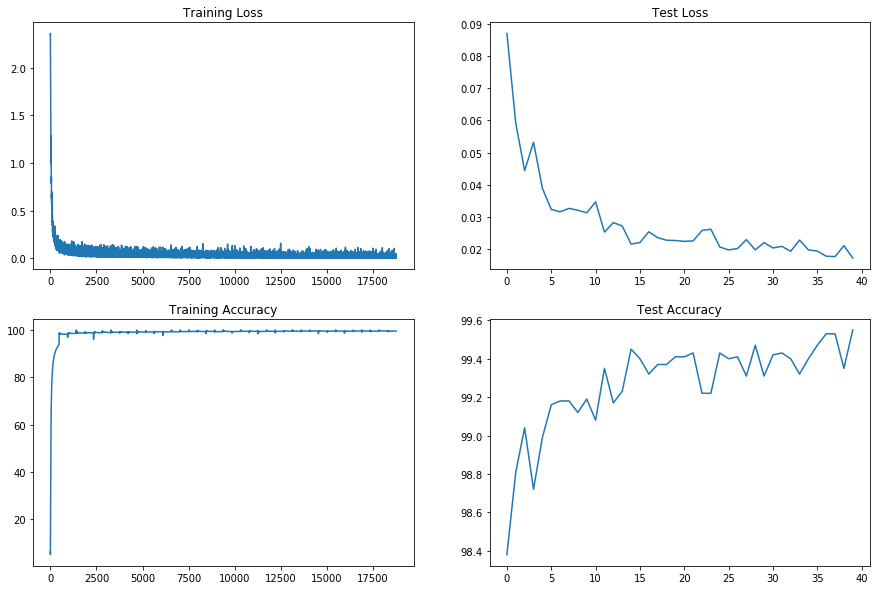

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")